In [1]:
import sys
import librosa
from IPython.display import Audio
sys.path.append('../')

import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import random

from vocal_patterns.interface.main import predict
from vocal_patterns.ml_logic.preprocessor import scaled_spectrogram, slice_waves, stretch_waveforms
from vocal_patterns.ml_logic.data import get_data
from vocal_patterns.ml_logic.registry import load_model

MLFLOW_TRACKING_URI https://mlflow.lewagon.ai


In [12]:
# data_raw = get_data()
# data_raw.head()
# test_file = data_raw.iloc[10]['path']
test_file = "/Users/jake/Desktop/rec_LW_elsa/Arp_elsa_1.wav"
# test_file

In [3]:
def plot_spectrogram_librosa(waveform, sr):
    # Compute the spectrogram
    Sxx = librosa.feature.melspectrogram(y=waveform, sr=sr)
    # Convert to dB scale
    Sxx_db = librosa.power_to_db(Sxx, ref=np.max)
    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(Sxx_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

In [4]:
def create_slices(waveform, sr):
 slice_waveforms = slice_waves(waveform, sr) # slices the original one. slice_waveforms is a list of the slices.
# one of the slices (w) is of shape (88200,)

 spectrograms = [] #this will contain my list of slices
 for w in slice_waveforms:
     normalized_spectrogram = scaled_spectrogram(w, sr) # shape = (128, 173, 1)
     spectrograms.append(normalized_spectrogram)
 spectrograms = np.array(spectrograms)
 return spectrograms

In [5]:
# Original
def run_prediction(spectrograms):
    raw_predictions = []
    model = load_model()
    for spectrogram in spectrograms:
        spectrogram_expanded = np.expand_dims(spectrogram, axis=0)
    
        prediction = predict(spectrogram_expanded, model) #predict is from main
        raw_predictions.append(prediction)

    # print("raw_predictions_sum", np.mean(raw_predictions, axis=0))
    prediction_map = {
        0: "Arpeggio",
        1: "Other",
        2: "Scale",
    }

    mean_prediction = np.mean(raw_predictions, axis=0)
    prediction = np.argmax(mean_prediction)
    confidence = np.max(mean_prediction) * 100
    prediction_str = prediction_map[prediction]

    return prediction_str, confidence


In [6]:
def noise_up_waveform(y, noise_level=0.1):
    np.random.normal(size=len(y))
    y_noisy = y + (noise_level * np.random.normal(size=len(y)))
    return y_noisy
   

In [7]:
def add_background_noise(waveform, sr, noise_level=0.8):
    sample = "/Users/jake/Desktop/office-ambience-6322.mp3"
    background_sample, sr = librosa.load(sample, sr=sr, mono=True)
    waveform_length = len(waveform)
    sample_length = len(background_sample)
    if sample_length > waveform_length:
        length_difference = sample_length - waveform_length
        # The goal here was to take a random slice of the background sample that is the same length as the waveform
        random_length = random.randint(20, length_difference)
        background_sample = background_sample[random_length:waveform_length+random_length]
        mixed_waveform = waveform + noise_level * background_sample
    return mixed_waveform, sr


In [8]:
test_waveform, sr = librosa.load(test_file, sr=22050)

Audio(test_waveform,rate=22050)

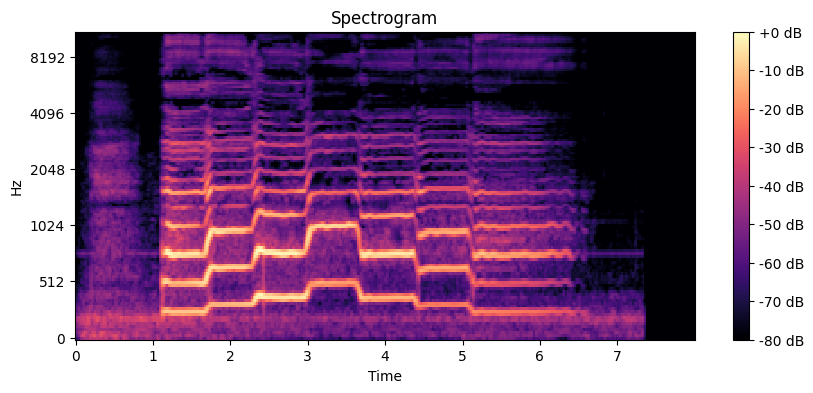

{'frame_size': 88200, 'hop_length': 22050, 'sr': 22050, 'waveform': 176400}
num_snippets 5

Load [Production] model from MLflow...
✅ Model loaded from MLflow
1/1 [==============================] - 0s 12ms/step
Prediction: Arpeggio
Confidence: 85.08034944534302


In [13]:
#ORIGINAL
from vocal_patterns.ml_logic.preprocessor import preprocess_predict


orig_waveform, sr = librosa.load(test_file, sr=22050)

plot_spectrogram_librosa(orig_waveform, sr)
processed = preprocess_predict(orig_waveform)
prediction_str, confidence = run_prediction(processed)
print("Prediction:", prediction_str)
print("Confidence:", confidence)
Audio(orig_waveform, rate=sr)

In [10]:
# NOISE
# noise_waveform = noise_up_waveform(orig_waveform, noise_level=0.01)

# plot_spectrogram_librosa(noise_waveform, sr)
# spectrograms = create_slices(noise_waveform, sr)
# prediction_str, confidence = run_prediction(spectrograms)
# print("Prediction:", prediction_str)
# print("Confidence:", confidence)
# Audio(noise_waveform, rate=sr)

In [11]:
# WITH background noise
# w_back_waveform, sr = add_background_noise(test_waveform, sr, noise_level=3)

# plot_spectrogram_librosa(w_back_waveform, sr)
# spectrograms = create_slices(w_back_waveform, sr)
# prediction_str, confidence = run_prediction(spectrograms)
# print("Prediction:", prediction_str)
# print("Confidence:", confidence)
# Audio(w_back_waveform, rate=sr)
